In [740]:
# General Python
import sys
import os
sys.path.append('./')

# Data structures
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
dpi = 200
mpl.rc("savefig", dpi=dpi)
%matplotlib inline
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
from scipy import stats
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
import seaborn as sns
import math
import re

from lmfit import minimize, Parameters, report_fit
from matplotlib.colors import LogNorm

#additional imports
import pandas as pd
from Bio import SeqIO, SeqRecord,Seq
import mkl_random
import random

import os
import subprocess
from Bio import Entrez, SeqIO
from copy import deepcopy
from pathlib import Path

import datetime
import time
import json
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

import seaborn as sb

import re


## Define plotting functions

In [741]:
#input desired subsetted mutagenesis window, plate number as ID, and subsetted dataframe
#return a histogram representing counts of mutants at each position within the window
#and among categories of variants outside the window/not single AA changes
def makeVariantHist(windowNum, plateNum, inputDF):
    #assign mutational region based on input to imports above (where windowNum is specified)
    residue_start = mutationD[windowNum][0]
    residue_end=mutationD[windowNum][1]

    #make list used for bar chart labels, these are categories that will be grouped from 
    #multiple residue positions
    variant_list=['WT', 'indel','5-UTR','outside']

    #create list of individual AA positions that will be counted for this plot
    #list of AA residues in window
    aa_list= list(mutationD[windowNum][2])
    #list of numerical positions of each residue
    aa_num_list=range(residue_start, residue_end+1)
    #concatenated item by item to give list of aa+pos for all residues in window
    res_list= [i + str(j) for i,j in zip (aa_list, aa_num_list)]

    #extend grouped residue categories list with individual AAs
    variant_list.extend(res_list)

    #create new dataframe and add contents of residue/grouped residue containing list
    plotDF=pd.DataFrame()
    plotDF['Genotype']=variant_list

    #make list of all mutated sites
    single_sub_sites=[]

    #pick out positions from substitution dataframe
    for index, val in inputDF.iterrows():
        sub=str(val.amino_acid_sub)
        codon_num=val.codon

        if codon_num==0:
            single_sub_sites.append("WT")
        if codon_num== -2:
            single_sub_sites.append("indel")
        if codon_num== -1:
            single_sub_sites.append("5-UTR")

        if "_" in sub:
            sub_list=sub.split('_')
            aa_num_corrected=int(sub_list[1])
            ref_pos=str(sub_list[0])+str(aa_num_corrected)

            if ((aa_num_corrected > residue_end) or (aa_num_corrected < residue_start)) and aa_num_corrected >-1:
                single_sub_sites.append("outside")

            else:
                single_sub_sites.append(ref_pos)

    #count occurences of each and add to dataframe containing reference seq
    count=[]
    for index, val in plotDF.iterrows():
        num_elements=single_sub_sites.count(val.Genotype)
        count.append(num_elements)

    plotDF['count']=count
    
    #make fig and ax
    fig=plt.figure(figsize=(20,10))
    ax=plt.gca()
    
    #make bar plot using genotype and count data
    ax.bar(list(plotDF['Genotype']),list(plotDF['count']), color='dodgerblue')
    
    #make string for title
    title="Plate " + str(plateNum) + ": Count of SpAP WT, indel and point mutants (n = "+str(len(inputDF))+" variants from "+str(dataDF['i7_barcode'].nunique())+" barcodes)"

    plt.ylabel('count',fontsize=24)
    plt.yticks(np.arange(0, plotDF['count'].max(), 5), fontsize=16)
    plt.xlabel('Residue (SpAP window '+str(windowNum)+", " +str(residue_start)+"-"+str(residue_end)+')',fontsize=24)
    plt.xticks(rotation=45, fontsize=16)
    plt.title(title, fontsize=24)
    plt.tight_layout()
    plt.close()
    return fig

In [742]:
#input desired subsetted mutagenesis window, plate number as ID, and subsetted dataframe
#return a histogram representing counts of mutants at each position within the window
#and among categories of variants outside the window/not single AA changes
def makeVariantHist_full(inputDF):
    #assign mutational region based on input to imports above (where windowNum is specified)
    residue_start = 1
    residue_end=542

    #make list used for bar chart labels, these are categories that will be grouped from 
    #multiple residue positions
    variant_list=['WT', 'indel','5-UTR','outside']

    #create list of individual AA positions that will be counted for this plot
    #list of AA residues in window
    aa_list= protein
    #list of numerical positions of each residue
    aa_num_list=range(residue_start, residue_end+1)
    #concatenated item by item to give list of aa+pos for all residues in window
    res_list= [i + str(j) for i,j in zip (aa_list, aa_num_list)]

    #extend grouped residue categories list with individual AAs
    variant_list.extend(res_list)

    #create new dataframe and add contents of residue/grouped residue containing list
    plotDF=pd.DataFrame()
    plotDF['Genotype']=variant_list

    #make list of all mutated sites
    single_sub_sites=[]

    #pick out positions from substitution dataframe
    for index, val in inputDF.iterrows():
        sub=str(val.amino_acid_sub)
        codon_num=val.codon

        if codon_num==0:
            single_sub_sites.append("WT")
        if codon_num== -2:
            single_sub_sites.append("indel")
        if codon_num== -1:
            single_sub_sites.append("5-UTR")

        if "_" in sub:
            sub_list=sub.split('_')
            aa_num_corrected=int(sub_list[1])
            ref_pos=str(sub_list[0])+str(aa_num_corrected)

            if ((aa_num_corrected > residue_end) or (aa_num_corrected < residue_start)) and aa_num_corrected >-1:
                single_sub_sites.append("outside")

            else:
                single_sub_sites.append(ref_pos)

    #count occurences of each and add to dataframe containing reference seq
    count=[]
    for index, val in plotDF.iterrows():
        num_elements=single_sub_sites.count(val.Genotype)
        count.append(num_elements)

    plotDF['count']=count
    plotDF = plotDF[plotDF.Genotype != 'WT']
    plotDF = plotDF[plotDF.Genotype != 'indel']
    plotDF = plotDF[plotDF.Genotype != '5-UTR']
    plotDF = plotDF[plotDF.Genotype != 'outside']   
    #make fig and ax
    fig=plt.figure(figsize=(60,10))
    ax=plt.gca()
    
    #make bar plot using genotype and count data
    ax.bar(list(plotDF['Genotype']),list(plotDF['count']), color='dodgerblue')
    
    #make string for title
    title="All single variant mutants across SpAP windows 1-13"

    plt.ylabel('count',fontsize=24)
    plt.yticks(np.arange(0, plotDF['count'].max(), 5), fontsize=24)
    plt.xlabel('Residue (SpAP All, residues 2-542)',fontsize=18)
    plt.xticks(ticks = ['M1','G542'],rotation=45, fontsize=24)
    plt.title(title, fontsize=24)
    plt.tight_layout()
    plt.close()
    return fig

## 2. Import csvs from mutant calling notebook

In [743]:
#import dataframe containing lists of mutants with single AA substitutions
combinedDF=pd.read_csv('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/mutant_calling/csv_files/plates_1-13_mutant_calling_all_AA_subs.csv')

In [744]:
combinedDF.head()

,Unnamed: 0,codon,refSeq,altSeq,filter,fw_WT,rv_WT,fw_alt,rv_alt,position,i7_barcode,barcode_codon_index,amino_acid_sub,WT_sum,var_sum,ratio_var,plate,well
0,0,28,A,G,228.0,1,0,110,53,154,1001,1001_28,I_28_V,0,81,inf,1,233
1,1,15,C,G,225.0,0,0,11,10,115,1002,1002_15,R_15_V,0,21,inf,1,234
2,2,8,C,T,228.0,3,7,309,175,95,1003,1003_8,A_8_V,10,485,48.5,1,235
3,3,15,C,G,172.0,1,0,7,2,115,1006,1006_15,R_15_V,1,9,9.0,1,238
4,4,23,A,G,228.0,1,0,258,92,139,1007,1007_23,K_23_V,1,519,519.0,1,239


## 3. Generate dataframes with variants 1, 2, 3 or more substitutions

In [745]:
print(combinedDF['i7_barcode'].nunique())
#get barcodes with only one variant
singlesDF=combinedDF.groupby('i7_barcode').filter(lambda x: len(x) < 2)
# singlesDF=singlesDF.loc[singlesDF['ratio_var']>100]
print(singlesDF['i7_barcode'].nunique())

#get barcodes with two variants
doublesDF=combinedDF.groupby('i7_barcode').filter(lambda x: len(x) == 2)
print(doublesDF['i7_barcode'].nunique())


triplesDF=combinedDF.groupby('i7_barcode').filter(lambda x: len(x) > 2)
print(triplesDF['i7_barcode'].nunique())


# 3029
# 2056
# 761
# 212



3029
2056
761
212


In [746]:
print(len(singlesDF))

2056


## Rough estimate whether doubles are same read (linked) or not

<Figure size 432x288 with 0 Axes>

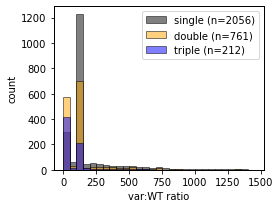

In [808]:
#set the value globally
plt.rcParams['axes.linewidth'] = 1 
singles_ratio = singlesDF['ratio_var'].tolist()
singles_ratio_no_inf=[]


for i in singles_ratio:
    #for reads with infinite ratio, convert to 100
    if i > 10e8:
        singles_ratio_no_inf.append(100)
    else:
        singles_ratio_no_inf.append(i)
        
doubles_ratio = doublesDF['ratio_var'].tolist()
doubles_ratio_no_inf=[]
for i in doubles_ratio:
    #for reads with infinite ratio, convert to 100
    if i > 10e8:
        doubles_ratio_no_inf.append(100)
    else:
        doubles_ratio_no_inf.append(i)
        
triples_ratio = triplesDF['ratio_var'].tolist()

triples_ratio_no_inf=[]
for i in triples_ratio:
    #for reads with infinite ratio, convert to 100
    if i > 10e8:
        triples_ratio_no_inf.append(100)
    else:
        triples_ratio_no_inf.append(i)
#make histogram
plt.clf()
plt.figure(figsize=(4,3))
plt.hist(singles_ratio_no_inf, bins=np.arange(0,1500,50), alpha=0.5, color='black', edgecolor='k',label="single (n=2056)")
plt.hist(doubles_ratio_no_inf, bins=np.arange(0,1500,50), alpha=0.5, color='orange',edgecolor='k', label="double (n=761)")
plt.hist(triples_ratio_no_inf, bins=np.arange(0,1500,50), alpha=0.5, color='blue',edgecolor='k', label="triple (n=212)")
plt.legend(loc='upper right')
plt.xlabel("var:WT ratio")
plt.ylabel("count")
# plt.xlim(0,200)
plt.tight_layout()

# plt.savefig('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/mutant_calling/csv_files/origin_of_doubles/20210604_singles-doubles-triples_histogram_ratio.png')
# plt.savefig('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/mutant_calling/csv_files/origin_of_doubles/20210604_singles-doubles-triples_histogram_ratio.pdf')

<Figure size 432x288 with 0 Axes>

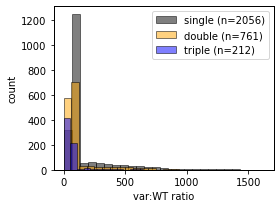

In [818]:
#set the value globally
plt.rcParams['axes.linewidth'] = 1 
singles_ratio = singlesDF['ratio_var'].tolist()
singles_ratio_no_inf=[]


for i in singles_ratio:
    #for reads with infinite ratio, convert to 100
    if i > 10e8:
        singles_ratio_no_inf.append(100)
    else:
        singles_ratio_no_inf.append(i)
        
doubles_ratio = doublesDF['ratio_var'].tolist()
doubles_ratio_no_inf=[]
for i in doubles_ratio:
    #for reads with infinite ratio, convert to 100
    if i > 10e8:
        doubles_ratio_no_inf.append(100)
    else:
        doubles_ratio_no_inf.append(i)
        
triples_ratio = triplesDF['ratio_var'].tolist()

triples_ratio_no_inf=[]
for i in triples_ratio:
    #for reads with infinite ratio, convert to 100
    if i > 10e8:
        triples_ratio_no_inf.append(100)
    else:
        triples_ratio_no_inf.append(i)
#make histogram
plt.clf()
plt.figure(figsize=(4,3))
plt.hist(singles_ratio_no_inf, bins=25, alpha=0.5, color='black', edgecolor='k',label="single (n=2056)")
plt.hist(doubles_ratio_no_inf, bins=25, alpha=0.5, color='orange',edgecolor='k', label="double (n=761)")
plt.hist(triples_ratio_no_inf, bins=25, alpha=0.5, color='blue',edgecolor='k', label="triple (n=212)")
plt.legend(loc='upper right')
plt.xlabel("var:WT ratio")
plt.ylabel("count")
# plt.xlim(0,200)
plt.tight_layout()

plt.savefig('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/mutant_calling/csv_files/origin_of_doubles/20210604_singles-doubles-triples_histogram_ratio.png')
plt.savefig('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/mutant_calling/csv_files/origin_of_doubles/20210604_singles-doubles-triples_histogram_ratio.pdf')

## 4. Determine which single substitutions are intended vs unintended

### 4.1 -- Check that substitution is a) to the correct AA b) adjusted for locatin whether Val mutants, Ala mutants, or Ala-Ala synonymous mutants

In [768]:
#cast codon as int
singlesDF['codon'] = singlesDF['codon'].astype(np.int)

#copy singles dataframe to new DF for adding columns after loop
singlesDF_classified=singlesDF.copy()

#specify filter level
filter_level=0

#cull dataframe by var:WT filter level if desired
singlesDF_classified=singlesDF_classified.loc[singlesDF_classified['ratio_var'] >= filter_level]

#create lists to store identity of substituted AA (observed) and substituted AA (expected)
newAA_list=[]
expectedAA_list=[]

#iterate through dataframe to pull out observed and expected AAs for each codon
for index,val in singlesDF_classified.iterrows():
    
    #pull out old/new AA from column contain substituion in format [old]_[#]_[new]
    oldAA=val.amino_acid_sub.split('_')[0]
    newAA=val.amino_acid_sub.split('_')[2]
    newAA_list.append(newAA)
    
    #only desired codon subs between postions 2-542, so any codons mutated outside this window
    #will be incorrect
    if (val.codon >1) and (val.codon <= 542):
       
        #plates 1-8 encode val subs, unless val, in which case ala
        if val.plate < 8:
            if (oldAA == 'V'):
                expectedAA='A'
            else:
                expectedAA='V'
        
        #other plates encode ala subs, and the accidental substition of ala with synonymous ala
        else:
            if (oldAA == 'A'):
                expectedAA='A'
            else:
                expectedAA='A'
    
    #assign 'none' for codons outside of desired mutational window
    else:
        expectedAA='none'
    
    #add to expected AA list
    expectedAA_list.append(expectedAA)
    
#add columns to df containing observed (new) and expected AAs
singlesDF_classified['expected_AA']=expectedAA_list
singlesDF_classified['new_AA']=newAA_list


#use this operation to create a new column, whose value will be 'True' or 'False' based
#on the comparison of the new and expected AA columns
singlesDF_classified['intended']= singlesDF_classified['expected_AA'] == singlesDF_classified['new_AA']

## 4.2 -- Flag mutants that may be correct based on above criteria, but in the wrong sublibrary location

In [769]:
#define sublibrary boundaries
mutationD={1:[2,41],
           2:[42,89],
           3:[90,137],
           4:[138,185],
           5:[186,232],
           6:[233,279],
           7:[280,326],
           8:[327,356],
           9:[357,402],
           10:[403,448],
           11:[449,491],
           12:[492,517],
           13:[518,542]
          }

#store flagged indexes in list (not specifically barcodes)
flaggedIndexes=[]

#check that observed mutants lie within the boundaries of the above sublibraries
for i, j in mutationD.items():
    
    #make list of positions in this sublibary window
    codonL=np.arange(j[0],j[1]+1)
        
    #select only rows from plate i
    tempDF=singlesDF_classified.loc[singlesDF_classified['plate']==i]
    
    #get total count of intended singles
    intendedTempDF=tempDF.loc[tempDF['intended']==True]
    
    
    for index, entry in intendedTempDF.iterrows():
        if entry.codon not in codonL:
            flaggedIndexes.append(index)
        else:
            pass


#go through dataframe and change true entry to false for any flagged barcodes
for i in flaggedIndexes:
    print(singlesDF_classified.loc[i])
    singlesDF_classified.loc[i, 'intended']= False
    print(singlesDF_classified.loc[i])

Unnamed: 0                1277
codon                       57
refSeq                       T
altSeq                       A
filter                     225
fw_WT                        0
rv_WT                        0
fw_alt                     880
rv_alt                     439
position                   243
i7_barcode                2233
barcode_codon_index    2233_57
amino_acid_sub          A_57_A
WT_sum                       0
var_sum                    659
ratio_var                  inf
plate                       11
well                       313
expected_AA                  A
new_AA                       A
intended                  True
Name: 1277, dtype: object
Unnamed: 0                1277
codon                       57
refSeq                       T
altSeq                       A
filter                     225
fw_WT                        0
rv_WT                        0
fw_alt                     880
rv_alt                     439
position                   243
i7_barcode   

### print summary stats and export csv

In [770]:
#calculate number of intended vs unintended
print("unintended:")
numUNintended= len(singlesDF_classified.loc[singlesDF_classified['intended']==False])
print(numUNintended)
print("intended:")
numIntended= len(singlesDF_classified.loc[singlesDF_classified['intended']==True])
print(numIntended)

#calculate number of unique singles that were intended
intendedOnlyDF=singlesDF_classified.loc[singlesDF_classified['intended']==True]
numUnique=intendedOnlyDF['amino_acid_sub'].nunique()
print("unique:")
print(numUnique)

#export this DF
singlesDF_classified.to_csv('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/mutant_calling/csv_files/single_mutant_csvs/20210603_singles_'\
                            +str(len(singlesDF_classified))+"_total_" \
                            +str(numIntended)+"_intended_" \
                            +str(numUnique)+"_unique_" \
                            +str(filter_level)+'_threshold.csv')

unintended:
60
intended:
1996
unique:
507


## Scatter plot of var reads vs wt reads for single mutants (plates 1-13)
  
-Use DF containing only single substitutions && only INTENDED single substitutions

In [792]:
#modify dataframes generated in above cell here for plotting if desired
modifiedDF=intendedOnlyDF.copy()

filter_level=0 #this is the number of minimum reads and the minimum ratio of var:WT reads

modifiedDF_culled=modifiedDF.loc[(modifiedDF['var_sum']>=filter_level) & (modifiedDF['ratio_var']>=filter_level)]
print(len(modifiedDF_culled))
numUnique=modifiedDF_culled['amino_acid_sub'].nunique()
print(numUnique)


1996
507


In [793]:
#filter levels to calculate for each sublibrary
thresholds=[0,10,50,100,200,500,1000]

##calculate single mutant yields per sublibrary 
platesL=np.arange(1,14)

#make list of possible yields per sublibrary
sublibtotalL=[40,48,48,48,47,47,47,30,46,46,43,26,25,25]

#create dataframe to store stats
singlesyieldfinalDF=pd.DataFrame()

#add sublibrary/plate column to DF
singlesyieldfinalDF['sublibrary']=platesL

#use dataframe containing all intended single mutant subs to determine unique and yield for each
#sublibrary
for i in thresholds:
    #make list to store unique mutants in each sublibrary
    uniquepersubL=[]
    #make list to store fractional yield for each sublibrary
    fractionsubL=[]
    
    #formatted version with both values for manuscript table
    formattedL=[]
    
    #loop through plates and calculate yields at a single threshold level
    for plate in platesL:
        uniquepersubNum=(intendedOnlyDF.loc[(intendedOnlyDF['var_sum']>=i) & (intendedOnlyDF['ratio_var']>=i)&(intendedOnlyDF['plate']==plate)])['amino_acid_sub'].nunique()
        fracunique=round((uniquepersubNum/sublibtotalL[plate-1]),2)
        formattedStr=str(uniquepersubNum)+" ("+str(fracunique)+")"

        
        #add stats to lists for this threshold level
        uniquepersubL.append(uniquepersubNum)
        fractionsubL.append(fracunique)
        
        #make formatted column ready for table in manuscript
        formattedL.append(formattedStr)

    #add yields to DF for this threshold
    yield_col_name='yield_threshold_'+str(i)
    fraction_col_name='yield_threshold_frac_'+str(i)
    formatted_col_name='formated_'+str(i)
    singlesyieldfinalDF[yield_col_name]=uniquepersubL
    singlesyieldfinalDF[fraction_col_name]=fractionsubL
    singlesyieldfinalDF[formatted_col_name]=formattedL
#export csv with summary yields
singlesyieldfinalDF.set_index('sublibrary', inplace=True)
singlesyieldfinalDF.to_csv('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/mutant_calling/'+
                           'csv_files/single_mutant_csvs/unique_intended_per_sublibrary_thresholds/'+
                           '20210608_unique_intended_singles_per_sub_with_thresholds.csv')

/Users/mja/opt/miniconda3/envs/mutseq/lib/python3.8/site-packages/seaborn/axisgrid.py:2036: UserWarning: The marginal plotting function has changed to `histplot`, which does not accept the following argument(s): rug.
  warnings.warn(msg, UserWarning)


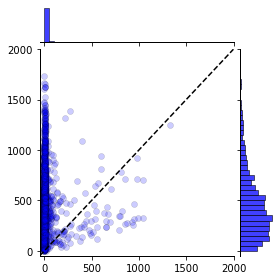

In [778]:
#set the value globally
plt.rcParams['axes.linewidth'] = 1 

g = sns.jointplot(x=WT_sum,
                  y=var_sum,
                  kind='scatter',
                  height=4,
                  space=0.2,
                  ratio=5,
                  color='blue',
                  alpha=0.2,
                  edgecolor='k',
                  marginal_kws=dict(bins=np.arange(0,1850,50), rug=True),
                  xlim=(-50,1850), ylim=(-50,1850),
                  marginal_ticks=False
              )

g.ax_joint.set_xlim((-50,2000))
g.ax_joint.set_ylim((-50,2000))
g.ax_joint.set_xticks(np.arange(0,2500,500))
g.ax_joint.set_yticks(np.arange(0,2500,500))

x=np.arange(-50,2000,1)
y=np.arange(-50,2000,1)
g.ax_joint.plot(x,y, color='k',linestyle='dashed')


#savefig
#Note, still slightly taller than wide, correct this in illustrator
plt.savefig('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/mutant_calling/scatter/read-sums/20210610_plates_1-13_'\
                            +str(len(scatterDF))+"_intended_" \
                            +str(numUnique)+"_unique_" \
                            +str(filter_level) \
                            +'_threshold_reads_jointplot.png')

plt.savefig('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/mutant_calling/scatter/read-sums/20210610_plates_1-13_'\
                            +str(len(scatterDF))+"_intended_" \
                            +str(numUnique)+"_unique_" \
                            +str(filter_level) \
                            +'_threshold_reads_jointplot.pdf')

In [779]:
print (len(var_sum))

1996


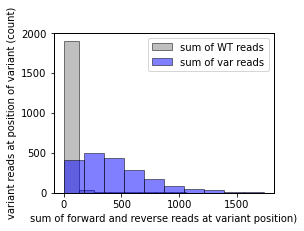

In [780]:
plt.figure(figsize=(4,3))
plt.hist(WTsum, bins=10, alpha=0.5, color='gray', edgecolor='k',label="sum of WT reads")
plt.hist(var_sum, bins=10, alpha=0.5, color='blue',edgecolor='k', label="sum of var reads")
plt.legend(loc='upper right')
plt.xlabel("sum of forward and reverse reads at variant position)")
plt.ylabel("variant reads at position of variant (count)")
plt.tight_layout()

## 4. Plot frequency and location of single mutants across entire ORF (FIGURE 7)

In [786]:
##Next, want to sum counts of True and False for each unique codon position

#this operation will group rows by codon position AND whether intended substitution column is
#True or False at that codon, then, count number of each occurence per codon and place in a new column
combinedDF_counts=intendedOnlyDF.groupby(by=['codon','intended']).agg('count')[['new_AA']].rename(columns={'new_AA':'counts'})


#pivot operation transforms values of the intended column (true or false) into new columns, whose values
#are counts for each codon. Codons that a present at least once but lacking a True or False count will return
#NaN, which is filled by 0
combinedDF_counts_pivot=pd.pivot_table(combinedDF_counts.reset_index(), values = ['counts'], index=['codon'], columns=['intended']).fillna(0)

#reset index so codons can easily be saved to a list (harder to do this without this step because still a multi-index DF)
combinedDF_counts_pivot_reset = combinedDF_counts_pivot.reset_index()

#get names of each multi-indexed column
print(combinedDF_counts_pivot_reset.columns.values)

[('codon', '') ('counts', True)]


In [787]:
##Not all desired mutated codons were observed, so not listed in dataframe, however, 
#want to plot mutant frequencies across all desired positions, simple way to do this is to create a dataframe
#listing all codon positions and joining it to dataframe with codon/true/false columns


#make lists of codons and true/false counts and add to new dataframe, easier to do this
#than manipulate multi-index df from above

#extract columns as lists
codon_pos=combinedDF_counts_pivot_reset[('codon', '')].tolist()
true_counts=combinedDF_counts_pivot_reset[('counts', True)].tolist()
#add to new df
summaryDF=pd.DataFrame()
summaryDF['codon']=codon_pos
summaryDF['true_counts']=true_counts
summaryDF.set_index('codon', inplace=True)


#create list containing all mutated positions of interest for plotting (only enzyme and eGFP containing ORF)
all_pos_list=np.arange(1, 790)
#add to new df
blanksDF=pd.DataFrame(data={'codon':all_pos_list})
blanksDF.set_index('codon', inplace=True)

#join with blanks df outer (opposite way will toss out codons missing from summaryDF)
plottingDF=blanksDF.join(summaryDF)

#finally, extract columns of this df to lists for bar plotting
codonList=plottingDF.index.tolist()
trueList=plottingDF['true_counts'].tolist()

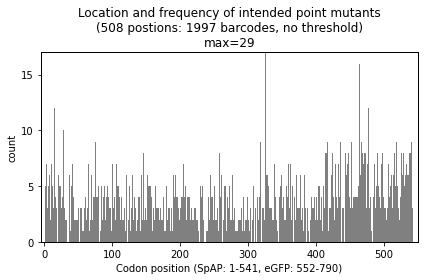

In [283]:
#define data used for each stack of stacked bar plot
p1 = plt.bar(codonList, trueList, width=1, color='gray')

plt.ylabel('count')
plt.xlabel('Codon position (SpAP: 1-541, eGFP: 552-790)')

plt.title('Location and frequency of intended point mutants\n(507 postions: 1996 barcodes, no threshold)\nmax=29')
plt.yticks([0,5,10,15,20,25,30])
plt.ylim(0,17)
plt.xlim(-5,550)
plt.tight_layout()


#save fig
plt.savefig('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/mutant_calling/csv_files/single_mutant_yield_plots/20210607_single_mutant_count_ORF_bar_plates_1-13.png')
plt.savefig('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/mutant_calling/csv_files/single_mutant_yield_plots/20210607_single_mutant_count_ORF_bar_plates_1-13.pdf')
plt.savefig('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/mutant_calling/csv_files/single_mutant_yield_plots/20210607_single_mutant_count_ORF_bar_plates_1-13.eps')

41
89
137
185
232
279
326
356
402
448
491
517
542


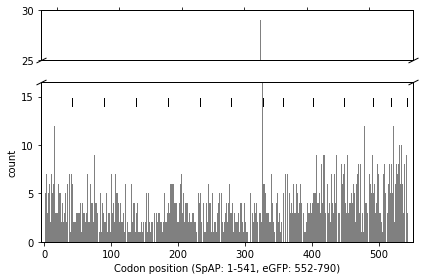

In [788]:
#define residue boundaries of mutational region (only intended mutants are included)
mutationD={1:[2,41],
           2:[42,89],
           3:[90,137],
           4:[138,185],
           5:[186,232],
           6:[233,279],
           7:[280,326],
           8:[327,356],
           9:[357,402],
           10:[403,448],
           11:[449,491],
           12:[492,517],
           13:[518,542]
          }

from matplotlib import gridspec

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.subplots_adjust(hspace=0.01)  # adjust space between axes
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 3.2]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

for index, val in mutationD.items():
    #get list subsets corresponding to each sublibrary window
    subsetCodonL=codonList[(val[0]-1):val[1]]
    subsetTrueL=np.nan_to_num(np.array(trueList[(val[0]-1):val[1]]))
    print(val[1])
    #add vertical line at end of sublibrary
    ax2.axvline(val[1], ymin=0.85, ymax=0.9,color='black', alpha=1, zorder=0, linewidth=1)
#     ax2.axvline(val[1], color='gray', alpha=1, zorder=0, linewidth=1, linestyle='dashed')


    #plot each sublibrary, vary color based on odd/even
    if index % 2 != 0:
        ax1.bar(subsetCodonL, subsetTrueL, width=1, color='gray', alpha=1, zorder=2)
        ax2.bar(subsetCodonL, subsetTrueL, width=1, color='gray', alpha=1, zorder=2)
    else:
        ax1.bar(subsetCodonL, subsetTrueL, width=1, color='gray', alpha=1, zorder=2)
        ax2.bar(subsetCodonL, subsetTrueL, width=1, color='gray', alpha=1, zorder=2)        

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(25, 30)  # outliers only
ax2.set_ylim(0, 16.5)  # most of the data        
        
# hide the spines between ax and ax2
# ax1.spines.bottom.set_visible(False)
# ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=10,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)


#edit plot
plt.ylabel('count')
plt.xlabel('Codon position (SpAP: 1-541, eGFP: 552-790)')
ax1.set_yticks([25,30])
ax2.set_yticks([0,5,10,15])


# plt.ylim(0,32)
plt.xlim(-5,550)
plt.tight_layout()


# #save fig
plt.savefig('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/mutant_calling/csv_files/single_mutant_yield_plots/20210607_single_mutant_count_ORF_bar_plates_1-13_sublib_grid_broken.png')
plt.savefig('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/mutant_calling/csv_files/single_mutant_yield_plots/20210607_single_mutant_count_ORF_bar_plates_1-13_sublib_grid_broken.pdf')

## Plot frequency distribution of number of single mutants per position

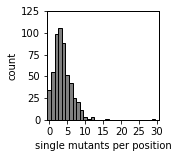

In [789]:
#set the value globally
plt.rcParams['axes.linewidth'] = 1 
from matplotlib.pyplot import figure
figure(figsize=(2,2))

#select only segment of freq list used in above figure that contains SpAP ORF
spapORFfreqs=np.array(trueList[1:542])

#convert nan to 0
spapORFfreqs=np.nan_to_num(spapORFfreqs)


plt.hist(spapORFfreqs, bins=np.arange(-0.5,31.5,1), color='gray',edgecolor='k', width=1.0)
plt.xlim(-0.5,30.5)
plt.xticks(np.arange(0,35,5));
plt.ylim(0,125)
plt.xlabel('single mutants per position')
plt.ylabel('count')

plt.savefig('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/comparison_with_simulations/mutants_per_pos/20210609_single_mut_per_pos_1996-507.png')
plt.savefig('/Users/mja/Appel_MutSequencing/2021_mut_seq_workup_II/analyses_from_py_notebooks/with_unpaired/comparison_with_simulations/mutants_per_pos/20210609_single_mut_per_pos_1996-507.pdf')

In [790]:
spapORFfreqs.sum()

1996.0